# Random Forest Model for TANAP Boundaries Prediction

This notebook implements and evaluates a Random Forest model for predicting TANAP boundaries in historical document scans.

## Model Overview
- **Task**: Multi-class classification (NONE, START, MIDDLE, END)
- **Algorithm**: Random Forest (ensemble of decision trees)
- **Features**: XML layout features + XMI NER features + sequence features
- **Advantages**: Handles non-linear relationships, feature interactions, robust to outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

In [2]:
# Load the feature dataset
df = pd.read_csv('../data/train/features_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['TANAP Boundaries'].value_counts())
print(f"\nTarget percentages:")
print(df['TANAP Boundaries'].value_counts(normalize=True) * 100)

Dataset shape: (16774, 69)

Target distribution:
TANAP Boundaries
MIDDLE    13058
NONE       1535
START      1091
END        1090
Name: count, dtype: int64

Target percentages:
TANAP Boundaries
MIDDLE    77.846667
NONE       9.151067
START      6.504114
END        6.498152
Name: proportion, dtype: float64


In [3]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['Scan File_Name', 'TANAP Boundaries']]
X = df[feature_cols]
y = df['TANAP Boundaries']

print(f"Number of features: {len(feature_cols)}")

# Handle missing values
missing_data = X.isnull().sum()
if missing_data.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_data[missing_data > 0])
    X = X.fillna(X.median())
else:
    print("\nNo missing values found.")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

Number of features: 67

No missing values found.

Label encoding:
0: END
1: MIDDLE
2: NONE
3: START


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Training set shape: (13419, 67)
Test set shape: (3355, 67)

Training set distribution:
0      872
1    10446
2     1228
3      873
Name: count, dtype: int64

Test set distribution:
0     218
1    2612
2     307
3     218
Name: count, dtype: int64


## Model Training and Hyperparameter Tuning

In [5]:
# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
print("Starting hyperparameter tuning...")
print("This may take several minutes due to the extensive parameter grid.")

# Use a smaller grid for faster execution
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    rf_model, 
    param_grid_small, 
    cv=3,  # Reduced CV folds for faster execution
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
This may take several minutes due to the extensive parameter grid.
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.8817


In [6]:
# Train final model with best parameters
best_rf_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Calculate training and test scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.8933
Training F1-score: 1.0000
Test F1-score: 0.8828


## Model Evaluation

In [7]:
# Detailed classification report
class_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(
    y_test, y_test_pred, 
    target_names=class_names,
    digits=4
))

Classification Report:
              precision    recall  f1-score   support

         END     0.7818    0.3945    0.5244       218
      MIDDLE     0.9110    0.9759    0.9423      2612
        NONE     0.8377    0.8241    0.8309       307
       START     0.7517    0.5000    0.6006       218

    accuracy                         0.8933      3355
   macro avg     0.8206    0.6736    0.7245      3355
weighted avg     0.8856    0.8933    0.8828      3355



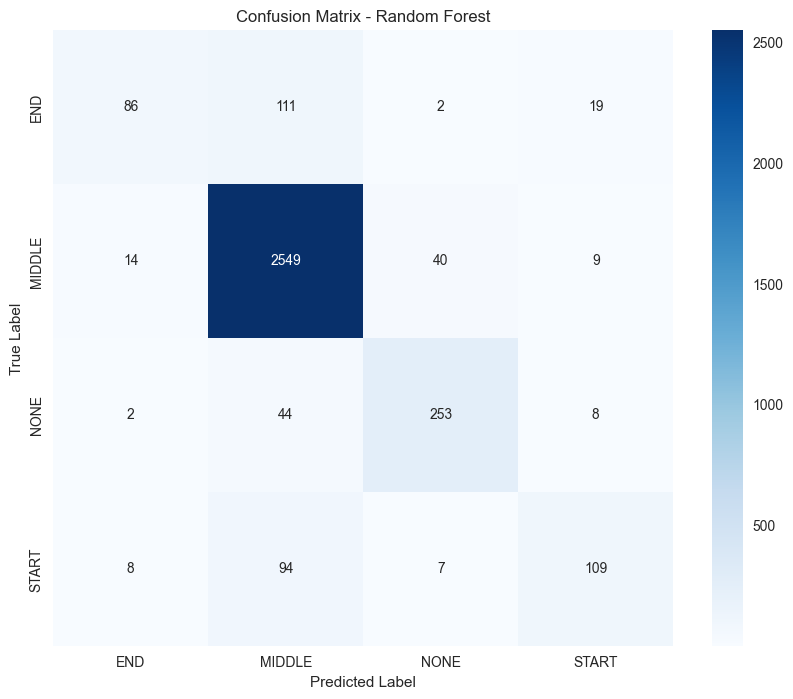


Per-class Metrics:
    Class  Precision  Recall  F1-Score  Support
0     END     0.7818  0.3945    0.5244      218
1  MIDDLE     0.9110  0.9759    0.9423     2612
2    NONE     0.8377  0.8241    0.8309      307
3   START     0.7517  0.5000    0.6006      218


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class Metrics:")
print(metrics_df.round(4))

## Feature Importance Analysis

Top 20 Most Important Features:
                  Feature  Importance
2               num_words    0.062541
1          num_text_lines    0.045677
44    next_num_text_lines    0.042572
66    position_normalized    0.041156
65   position_in_sequence    0.041008
35    punctuation_density    0.038213
21             num_tokens    0.035242
58  delta_next_num_tokens    0.033269
55        prev_num_tokens    0.032959
43    prev_num_text_lines    0.032415
28          misc_entities    0.030959
56        next_num_tokens    0.030079
36       dutch_indicators    0.029208
57  delta_prev_num_tokens    0.028420
52     next_num_sentences    0.027427
29    avg_sentence_length    0.025858
22     num_named_entities    0.022669
20          num_sentences    0.022520
30       avg_token_length    0.022293
51     prev_num_sentences    0.020264


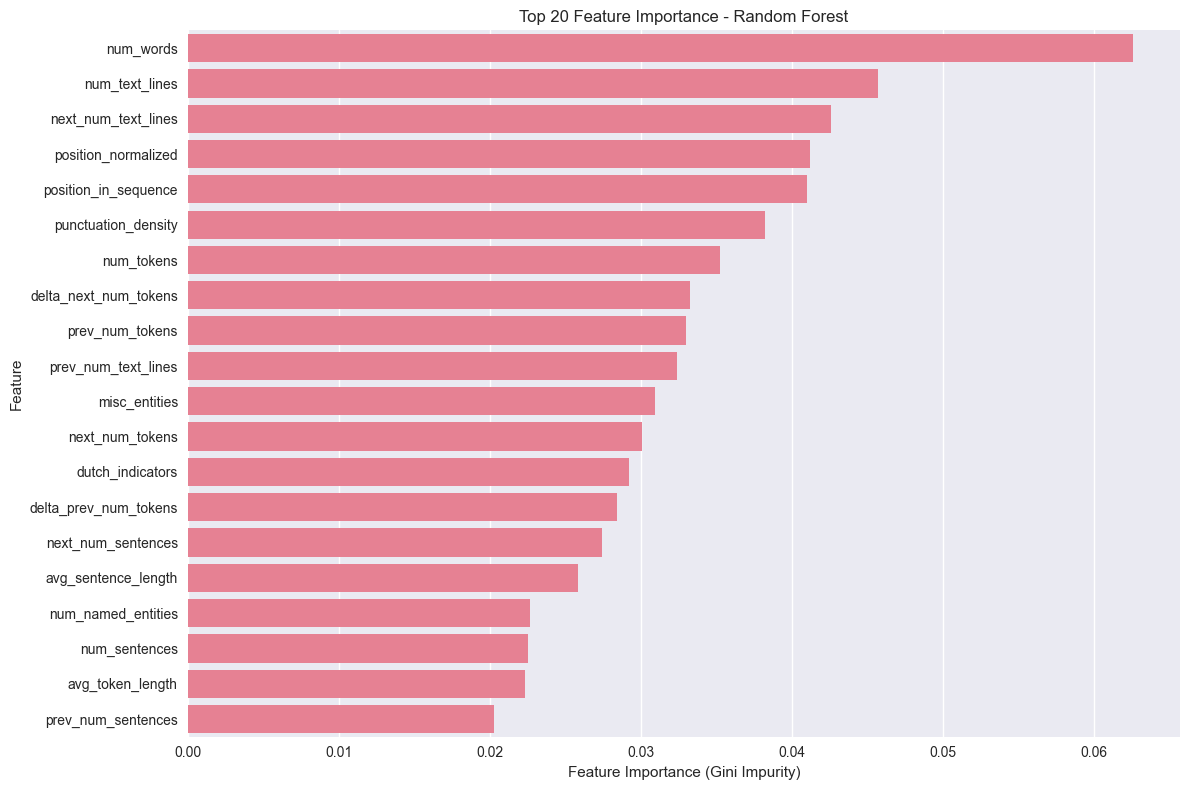

In [9]:
# Get feature importance from Random Forest
feature_importance = best_rf_model.feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))

# Plot top features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(data=top_features, y='Feature', x='Importance')
plt.title('Top 20 Feature Importance - Random Forest')
plt.xlabel('Feature Importance (Gini Impurity)')
plt.tight_layout()
plt.show()

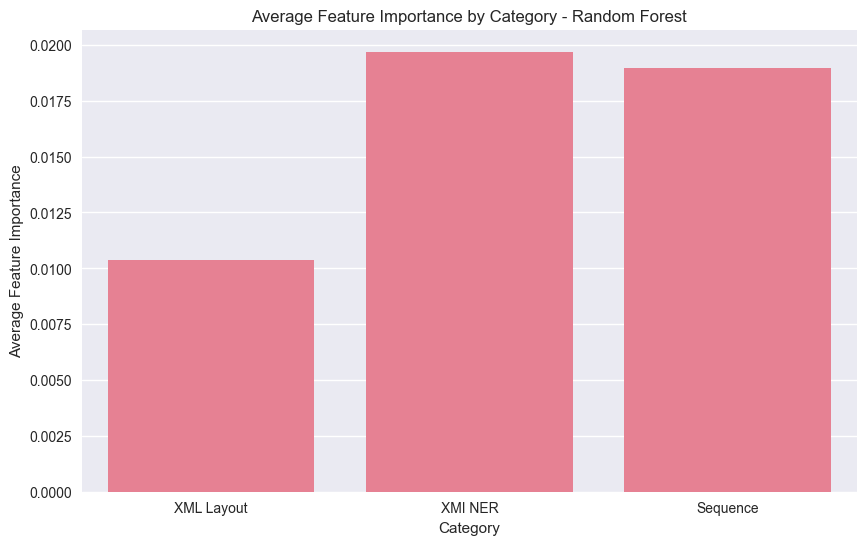

Feature Importance by Category:
     Category  Average_Importance
0  XML Layout            0.010372
1     XMI NER            0.019695
2    Sequence            0.018949


In [10]:
# Feature importance by category
xml_features = [f for f in feature_cols if any(keyword in f.lower() for keyword in 
                ['region', 'area', 'text_lines', 'coverage', 'spatial', 'header', 'paragraph'])]
xmi_features = [f for f in feature_cols if any(keyword in f.lower() for keyword in 
                ['sentence', 'token', 'entities', 'language', 'dutch', 'punctuation'])]
sequence_features = [f for f in feature_cols if any(keyword in f.lower() for keyword in 
                    ['prev_', 'next_', 'delta_', 'rolling_', 'position'])]

# Calculate average importance by category
xml_importance = feature_importance_df[feature_importance_df['Feature'].isin(xml_features)]['Importance'].mean()
xmi_importance = feature_importance_df[feature_importance_df['Feature'].isin(xmi_features)]['Importance'].mean()
sequence_importance = feature_importance_df[feature_importance_df['Feature'].isin(sequence_features)]['Importance'].mean()

category_importance = pd.DataFrame({
    'Category': ['XML Layout', 'XMI NER', 'Sequence'],
    'Average_Importance': [xml_importance, xmi_importance, sequence_importance]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=category_importance, x='Category', y='Average_Importance')
plt.title('Average Feature Importance by Category - Random Forest')
plt.ylabel('Average Feature Importance')
plt.show()

print("Feature Importance by Category:")
print(category_importance)

## Cross-Validation Analysis

5-Fold Cross-Validation Results:
Accuracy: 0.8942 (+/- 0.0102)
F1-Score: 0.8844 (+/- 0.0119)


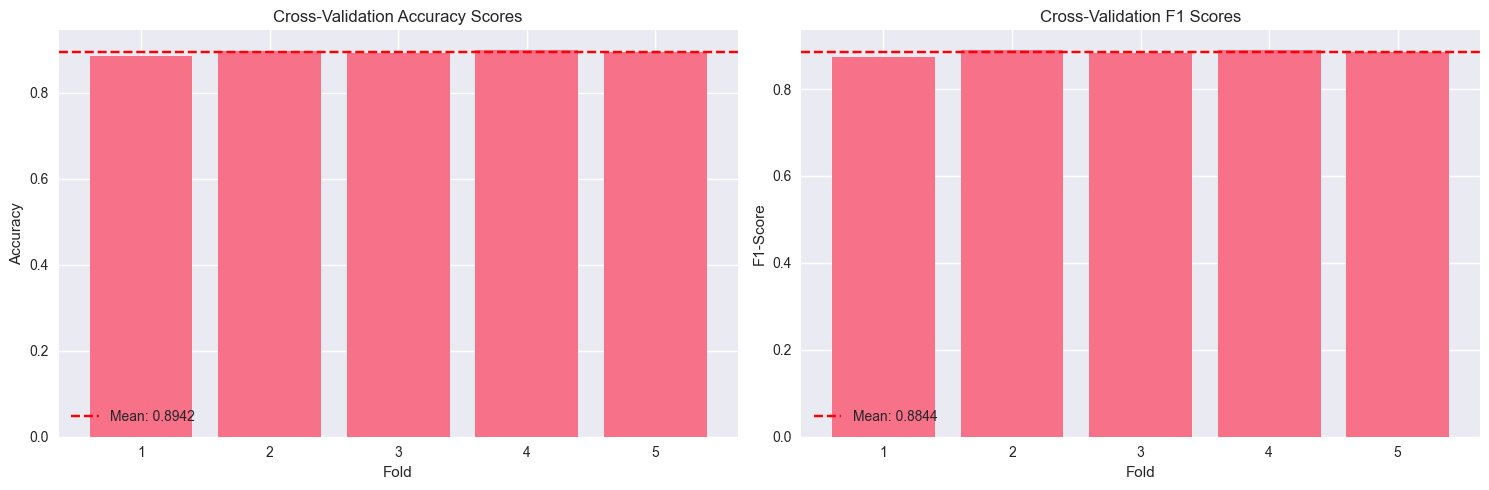

In [11]:
# Perform k-fold cross-validation
cv_scores_accuracy = cross_val_score(
    best_rf_model, X_train, y_train, cv=5, scoring='accuracy'
)
cv_scores_f1 = cross_val_score(
    best_rf_model, X_train, y_train, cv=5, scoring='f1_weighted'
)

print("5-Fold Cross-Validation Results:")
print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# Plot CV scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(range(1, 6), cv_scores_accuracy)
ax1.axhline(y=cv_scores_accuracy.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_accuracy.mean():.4f}')
ax1.set_title('Cross-Validation Accuracy Scores')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.bar(range(1, 6), cv_scores_f1)
ax2.axhline(y=cv_scores_f1.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_f1.mean():.4f}')
ax2.set_title('Cross-Validation F1 Scores')
ax2.set_xlabel('Fold')
ax2.set_ylabel('F1-Score')
ax2.legend()

plt.tight_layout()
plt.show()

## Model Interpretability - Tree Analysis

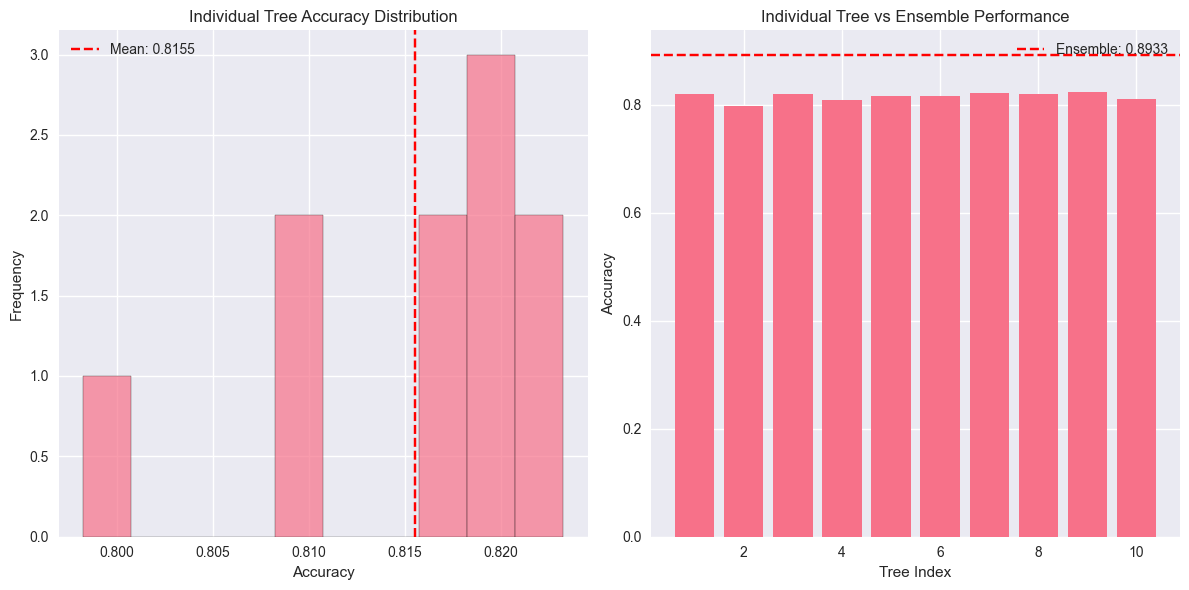

Individual tree accuracy: 0.8155 ± 0.0074
Ensemble accuracy: 0.8933
Ensemble improvement: 0.0778


In [12]:
# Analyze individual tree performance
n_estimators = best_rf_model.n_estimators
tree_accuracies = []

# Sample a few trees for analysis (to avoid memory issues)
sample_trees = min(10, n_estimators)
for i in range(sample_trees):
    tree = best_rf_model.estimators_[i]
    tree_pred = tree.predict(X_test)
    tree_acc = accuracy_score(y_test, tree_pred)
    tree_accuracies.append(tree_acc)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(tree_accuracies, bins=10, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(tree_accuracies), color='red', linestyle='--', 
           label=f'Mean: {np.mean(tree_accuracies):.4f}')
plt.title('Individual Tree Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(1, sample_trees + 1), tree_accuracies)
plt.axhline(y=test_accuracy, color='red', linestyle='--', 
           label=f'Ensemble: {test_accuracy:.4f}')
plt.title('Individual Tree vs Ensemble Performance')
plt.xlabel('Tree Index')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Individual tree accuracy: {np.mean(tree_accuracies):.4f} ± {np.std(tree_accuracies):.4f}")
print(f"Ensemble accuracy: {test_accuracy:.4f}")
print(f"Ensemble improvement: {test_accuracy - np.mean(tree_accuracies):.4f}")

## Results Summary and Analysis

In [13]:
# Create comprehensive results summary
results_summary = {
    'Model': 'Random Forest',
    'Best Parameters': grid_search.best_params_,
    'Training Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Training F1-Score': train_f1,
    'Test F1-Score': test_f1,
    'CV Accuracy Mean': cv_scores_accuracy.mean(),
    'CV Accuracy Std': cv_scores_accuracy.std(),
    'CV F1-Score Mean': cv_scores_f1.mean(),
    'CV F1-Score Std': cv_scores_f1.std(),
    'Number of Features': len(feature_cols),
    'Number of Trees': best_rf_model.n_estimators,
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Individual Tree Accuracy Mean': np.mean(tree_accuracies),
    'Ensemble Improvement': test_accuracy - np.mean(tree_accuracies)
}

print("RANDOM FOREST MODEL - FINAL RESULTS")
print("=" * 50)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Analysis and insights
print("\n" + "=" * 50)
print("ANALYSIS AND INSIGHTS")
print("=" * 50)

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:
    print("⚠️  Potential overfitting detected (training accuracy >> test accuracy)")
else:
    print("✅ Good generalization (no significant overfitting)")

# Model performance assessment
if test_accuracy > 0.8:
    print("✅ High model performance (accuracy > 80%)")
elif test_accuracy > 0.7:
    print("⚡ Moderate model performance (accuracy 70-80%)")
else:
    print("⚠️  Low model performance (accuracy < 70%)")

# Ensemble effectiveness
if results_summary['Ensemble Improvement'] > 0.02:
    print("✅ Strong ensemble effect (significant improvement over individual trees)")
else:
    print("⚡ Moderate ensemble effect")

# Feature importance insights
top_feature_importance = feature_importance_df.iloc[0]['Importance']
if top_feature_importance > 0.1:
    print("⚠️  High dependence on single feature - check for feature engineering opportunities")
else:
    print("✅ Well-distributed feature importance")

print(f"\n📊 Most important features for classification:")
for i, (feature, importance) in enumerate(feature_importance_df.head(5).values):
    print(f"   {i+1}. {feature}: {importance:.6f}")

print(f"\n🌳 Random Forest specific insights:")
print(f"   • {best_rf_model.n_estimators} decision trees in ensemble")
print(f"   • Max depth: {best_rf_model.max_depth}")
print(f"   • Min samples per leaf: {best_rf_model.min_samples_leaf}")
print(f"   • Feature subset size: {best_rf_model.max_features}")

RANDOM FOREST MODEL - FINAL RESULTS
Model: Random Forest
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Accuracy: 1.0000
Test Accuracy: 0.8933
Training F1-Score: 1.0000
Test F1-Score: 0.8828
CV Accuracy Mean: 0.8942
CV Accuracy Std: 0.0051
CV F1-Score Mean: 0.8844
CV F1-Score Std: 0.0060
Number of Features: 67
Number of Trees: 200
Training Samples: 13419
Test Samples: 3355
Individual Tree Accuracy Mean: 0.8155
Ensemble Improvement: 0.0778

ANALYSIS AND INSIGHTS
⚠️  Potential overfitting detected (training accuracy >> test accuracy)
✅ High model performance (accuracy > 80%)
✅ Strong ensemble effect (significant improvement over individual trees)
✅ Well-distributed feature importance

📊 Most important features for classification:
   1. num_words: 0.062541
   2. num_text_lines: 0.045677
   3. next_num_text_lines: 0.042572
   4. position_normalized: 0.041156
   5. position_in_sequence: 0.041008

🌳 Ra

## Save Model and Results

In [14]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model and preprocessing objects
joblib.dump(best_rf_model, '../models/random_forest_model.pkl')

# Save results summary
results_df = pd.DataFrame([results_summary])
results_df.to_csv('../models/random_forest_results.csv', index=False)

# Save feature importance
feature_importance_df.to_csv('../models/random_forest_feature_importance.csv', index=False)

# Save category importance
category_importance.to_csv('../models/random_forest_category_importance.csv', index=False)

print("Model and results saved successfully!")
print("Saved files:")
print("  - ../models/random_forest_model.pkl")
print("  - ../models/random_forest_results.csv")
print("  - ../models/random_forest_feature_importance.csv")
print("  - ../models/random_forest_category_importance.csv")

Model and results saved successfully!
Saved files:
  - ../models/random_forest_model.pkl
  - ../models/random_forest_results.csv
  - ../models/random_forest_feature_importance.csv
  - ../models/random_forest_category_importance.csv
